# Coding Assignment 2

**Authors**
* Ryan Fogle
    - rsfogle2@illinois.edu
    - UIN: 652628818
* Sean Enright
    - seanre2@illinois.edu
    - UIN: 661791377

**Contributions**

Ryan created the notebook and established the outline of the report, using the provided started code. In Part 1, he implemented `one_var_lasso()` in and provided an implementation of `MyLasso()` using sklearn scaling. He provided the initial implementation of the Part 2 simulation for all models in Case I, as well as generating the strip and box plots to summarize them graphically.

Sean adapted `MyLasso()` to use Numpy array operations to perform the offsetting and normalization, as well as transformation back to the original scale. He performed troubleshooting of `MyLasso()` to test and report its accuracy. He refactored the Part 2 simulation code to apply to both Case I and Case II of the simulation. He reported the statistics for each model.

Both team members contributed to the overall editing of the notebook, as well as the interpretation of the results in Part 2.

## Part 1: Implement Lasso

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Set random seed to the last four digits of our UINs
np.random.seed(8818 + 1377)

### Load Data

In [3]:
myData = pd.read_csv("Coding2_Data.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [4]:
X.shape, len(y)

((506, 13), 506)

### CD for Lasso

In [5]:
import numpy.typing as npt

def one_var_lasso(r: npt.NDArray, x: npt.NDArray, lam):
    
    #################
    # Your CODE
    #################
    
    # x == z
    # v == r

    z2 = (x.T @ x).sum()
    a = r.T @ x / z2
    n = 2 * x.shape[0] * lam / z2

    if a > n/2:
        return a - n/2
    elif np.abs(a) <= n/2:
        return 0
    elif a < -n/2:
        return a + n/2

In [6]:
from sklearn.preprocessing import StandardScaler

def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 
    ##############################
    
    # Centers
    y_mean = y.mean()
    X_mean = X.mean(axis=0)

    # Scale
    X_se = X.std(axis=0)

    # Centering and scaling of X
    newX = (X - X_mean) / X_se

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y
    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[, 1]
    ##############################

    # Scale back
    B[1:, :] = B[1:, :] / X_se[:, np.newaxis]
    
    # Add in new intercepts
    B[0, :] = y_mean - (X_mean[np.newaxis, :] @ B[1:, :]).squeeze()
    
    return(B)

In [7]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.30999458351285203, 0.49974219884805027)

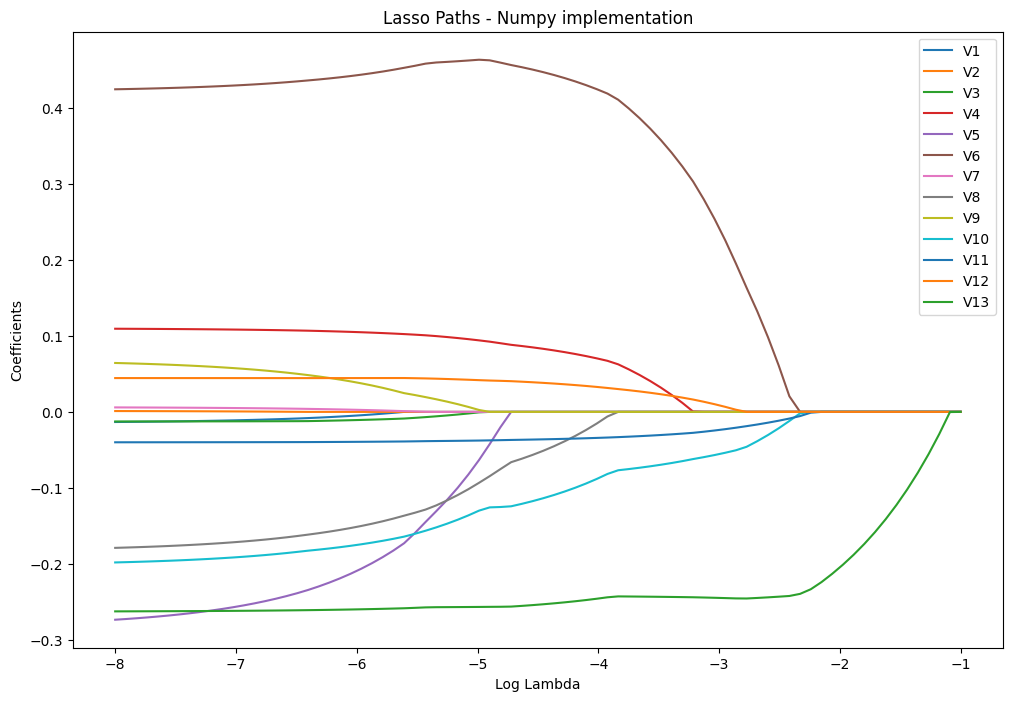

In [8]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

### Check the Accuracy
The output of our algorithm is compared against the output from glmnet. The maximum difference between the two coefficient matrices should be lass than 0.005.

In [9]:
lasso_coef = pd.read_csv("Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [10]:
abs(myout - lasso_coef).max()

0.004645317415915784

## Part II: Simulation Study

### Code for Six Procedures

The following code is shared by both Case I and Case II below.

Six prediction procedures are defined:
* Linear regression with all features
* Ridge regression using `lambda.min`
* Lasso with `lambda.min`
* Lasso with `lambda.1se`
* Lasso refit from the model with `lambda.1se`
* Principal components regression



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [12]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = LinearRegression().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [13]:
class LassoBase:
    """Predict with Lasso Regression variants
        Note: X_train and X_test must be centered and scaled"""
    def __init__(self, X_train, y_train, n_jobs=6):
        self.X_train = X_train
        self.y_train = y_train

        # Lasso
        lasso_alphas = np.logspace(-10, 1, 100)
        lassocv = LassoCV(alphas = lasso_alphas, cv = 10, n_jobs=n_jobs)
        lassocv.fit(X_train, y_train)
        cv_alphas = lassocv.alphas_
        mean_mse = np.mean(lassocv.mse_path_, axis=1)
        min_idx = np.argmin(mean_mse)

        # Minimum
        self.alpha_min = cv_alphas[min_idx]

        # 1se
        std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 
        threshold = mean_mse[min_idx] + std_mse[min_idx]
        self.alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

        # Refit
        self.nonzero_indices = None
    
    def min(self, X_test):
        """Regression with lambda.min"""
        lasso_model_min = Lasso(alpha = self.alpha_min, max_iter=10000)
        lasso_model_min.fit(self.X_train, self.y_train)
        return lasso_model_min.predict(X_test)
    
    def one_se(self, X_test):
        """Regression with lambda.1se"""
        lasso_model_1se = Lasso(alpha = self.alpha_1se, max_iter=10000)
        lasso_model_1se.fit(self.X_train, self.y_train)
        self.nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
        return lasso_model_1se.predict(X_test)
    
    def refit(self, X_test):
        """Refit regression from lambda.1se"""
        lm_refit = LinearRegression()
        lm_refit.fit(self.X_train.iloc[:, self.nonzero_indices],
                     self.y_train)
        return lm_refit.predict(X_test.iloc[:, self.nonzero_indices])


def full_model(X_train, y_train, X_test):
    """Predict with Full Linear Model"""
    full = LinearRegression()
    full.fit(X_train, y_train)
    return full.predict(X_test)

def ridge_regression(X_train, y_train, X_test):
    """Predict with Ridge Regression
        Note: X_train and X_test must be centered and scaled"""
    # Ridge regression
    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10,
                      scoring = 'neg_mean_squared_error')
    ridgecv.fit(X_train, y_train)
    ridge_model = Ridge(alpha = ridgecv.alpha_)
    ridge_model.fit(X_train, y_train)
    return ridge_model.predict(X_test)

def principal_component_regression(X_train, y_train, X_test):
    # perform PCR and train linear model.
    pcr = PCR()
    pcr.fit(X_train.to_numpy(), y_train.to_numpy())
    return pcr.predict(X_test.to_numpy())

In [14]:
def gen_sim_data(X, Y, pct_test=0.25):
    n = len(Y)
    indices = np.arange(0, n)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(pct_test * n))]
    train_ind = indices[len(test_ind):]

    # Splitting the data into training and testing sets
    X_train = X.iloc[train_ind]
    y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    y_test = Y[test_ind]

    # We need to scale data for Ridge and Lasso because they cannot normalize like R. 
    # Scaler
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test, X_train_scale, X_test_scale

### Case I

This simulation uses the data in `Coding2_Data2.csv`, which has 91 columns (1 response and 90 predictors), and 506 observations. The first 14 columns are the same data used in Part I.

In [15]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data2.csv"
myData = pd.read_csv(url)
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [16]:
X.shape, len(Y)

((506, 91), 506)

#### Simulation

In this simulation, each of the six models is used to for prediction with the `Coding2_Data2.csv` data, and their error is compared via mean squared prediction error (MSPE). The following procedure is carried out for 50 iterations:
1) Partition data into 75% training and 25% test sets
2) Fit training data with all six models, including:
    * Linear regression with all features
    * Ridge regression using `lambda.min`
    * Lasso with `lambda.min`
    * Lasso with `lambda.1se`
    * Lasso refit from the model with `lambda.1se`
    * Principal components regression
3) Predict response with test data
4) Evaluate MSPE

In [17]:
from tqdm import tqdm
# from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence errors
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [18]:
n_models = 6
n_sims = 50
data = []
n_jobs = 6

for i in tqdm(range(n_sims), total=n_sims):
    X_train, y_train, X_test, y_test, X_train_scale, X_test_scale = gen_sim_data(X, Y,
                                                                                 pct_test=0.25)
    lasso = LassoBase(X_train, y_train, n_jobs=n_jobs)
    predictions = (
        mean_squared_error(y_test, full_model(X_train, y_train, X_test)),
        mean_squared_error(y_test, ridge_regression(X_train_scale, y_train, X_test_scale)),
        mean_squared_error(y_test, lasso.min(X_test)),
        mean_squared_error(y_test, lasso.one_se(X_test)),
        mean_squared_error(y_test, lasso.refit(X_test)),
        mean_squared_error(y_test, principal_component_regression(X_train, y_train, X_test))
    )
    data.append(predictions)
    
case_i_df = pd.DataFrame(data, columns=['Full', 'Ridge.min', 'Lasso.min', 'Lasso.1se', 'L.Refit', 'PCR'])

100%|██████████| 50/50 [03:40<00:00,  4.41s/it]


#### Statistics

The following statistics are reported for the simulation MPSE data:
* Standard deviation (std)
* Minimim (min)
* Lower quartile (25%)
* Median (50%)
* Upper quartile (75%)
* Maximum (max)

In [19]:
case_i_df.describe().drop(['count', 'mean'])

,Full,Ridge.min,Lasso.min,Lasso.1se,L.Refit,PCR
std,0.006909,0.005136,0.005744,0.005256,0.006272,0.005643
min,0.021797,0.020307,0.019855,0.017187,0.017747,0.019460
25%,0.027346,0.025850,0.025982,0.028413,0.026709,0.027563
50%,0.030154,0.028597,0.028909,0.030481,0.029997,0.031076
75%,0.035556,0.030775,0.032028,0.033747,0.032668,0.034413
max,0.054767,0.050596,0.052829,0.041111,0.054375,0.052326


#### Graphical Summary

The MSPE for each model is presented in the boxplot and strip charts below.

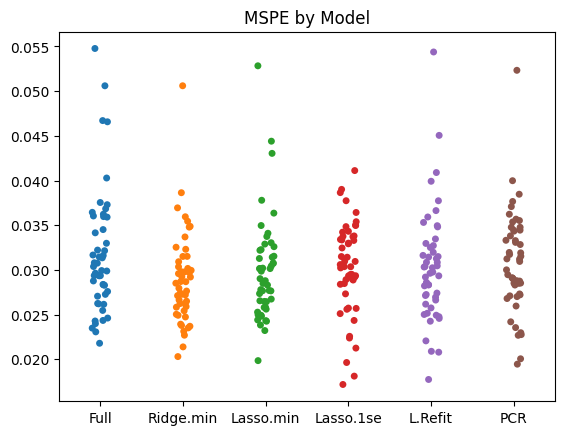

In [20]:
import seaborn as sns

# Strip chart
plt.title('MSPE by Model')
sns.stripplot(case_i_df)
plt.show()

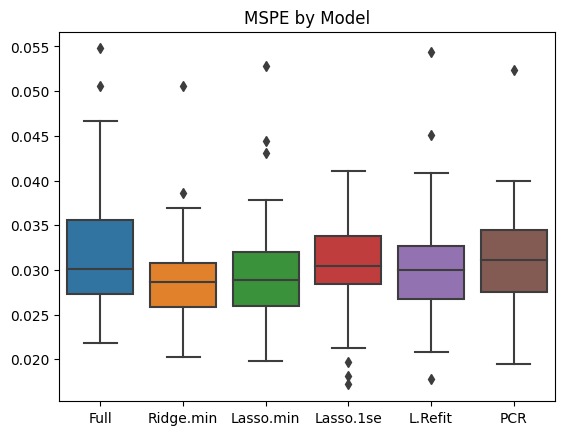

In [21]:
# Box plot
plt.title('MSPE by Model')
sns.boxplot(case_i_df)
plt.show()

#### Discussion

**Which procedure or procedures yield the best performance in terms of MSPE?**

Ridge.min and Lasso.min yielded the best average MSPE.

**Conversely, which procedure or procedures show the poorest performance?**

PCR shows the worst performance.

**In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?**

Lasso.min

**Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?**

Yes, L.Refit outpreformed Lasso.1se.

**Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?**

No, the full model performance was comparable to that of the variable selection or shrinkge models. Therefore, the added benefit of doing variable selection is minimal. For this case, $n \gg p$, so the full linear regression model has low variance and does not benefit much from regularization.

### Case II

This simulation uses the data in `Coding2_Data3.csv`, which has 591 columns (1 response and 590 predictors), and 506 observations. The first 92 columns are the same data used in Part II Case 1.

In [22]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data3.csv"
myData = pd.read_csv(url)
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [23]:
X.shape, len(Y)

((506, 591), 506)

#### Simulation

In this simulation, each of the six models is used to for prediction with the `Coding2_Data3.csv` data, and their error is compared via mean squared prediction error (MSPE). The following procedure is carried out for 50 iterations:
1) Partition data into 75% training and 25% test sets
2) Fit training data with five of the available models. The full linear regression model is excluded. The included models are:
    * Ridge regression using `lambda.min`
    * Lasso with `lambda.min`
    * Lasso with `lambda.1se`
    * Lasso refit from the model with `lambda.1se`
    * Principal components regression
3) Predict response with test data
4) Evaluate MSPE

In [24]:
n_models = 5
n_sims = 50
data = []
n_jobs = 6

for i in tqdm(range(n_sims), total=n_sims):
    X_train, y_train, X_test, y_test, X_train_scale, X_test_scale = gen_sim_data(X, Y,
                                                                                 pct_test=0.25)
    lasso = LassoBase(X_train, y_train, n_jobs=n_jobs)
    predictions = (
        mean_squared_error(y_test, ridge_regression(X_train_scale, y_train, X_test_scale)),
        mean_squared_error(y_test, lasso.min(X_test)),
        mean_squared_error(y_test, lasso.one_se(X_test)),
        mean_squared_error(y_test, lasso.refit(X_test)),
        mean_squared_error(y_test, principal_component_regression(X_train, y_train, X_test))
    )
    data.append(predictions)
    
case_ii_df = pd.DataFrame(data, columns=['Ridge.min', 'Lasso.min', 'Lasso.1se', 'L.Refit', 'PCR'])

100%|██████████| 50/50 [16:47<00:00, 20.16s/it]


#### Statistics

The following statistics are reported for the simulation MPSE data:
* Standard deviation (std)
* Minimim (min)
* Lower quartile (25%)
* Median (50%)
* Upper quartile (75%)
* Maximum (max)

In [25]:
case_ii_df.describe().drop(['count', 'mean'])

,Ridge.min,Lasso.min,Lasso.1se,L.Refit,PCR
std,0.008598,0.008190,0.008856,0.008023,0.009989
min,0.084252,0.037507,0.037679,0.036662,0.033920
25%,0.097314,0.047081,0.048580,0.049048,0.050134
50%,0.102494,0.053573,0.055314,0.054084,0.056671
75%,0.107127,0.058741,0.061879,0.057982,0.062661
max,0.119026,0.066411,0.074557,0.068767,0.079990


#### Graphical Summary

The MSPE for each model is presented in the boxplot and strip charts below.

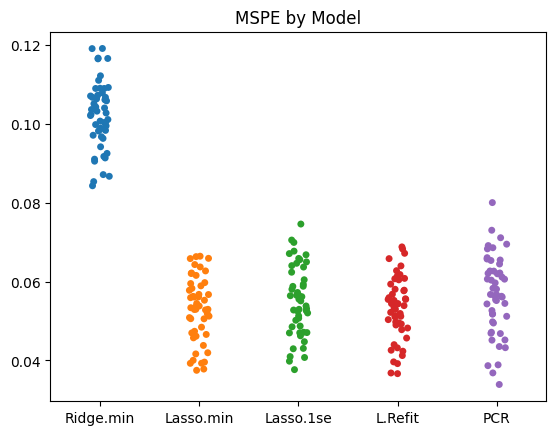

In [26]:
# Strip chart
plt.title('MSPE by Model')
sns.stripplot(case_ii_df)
plt.show()

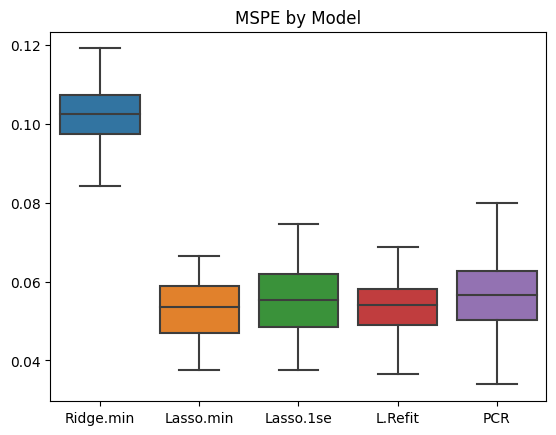

In [27]:
# Box plot
plt.title('MSPE by Model')
sns.boxplot(case_ii_df)
plt.show()

#### Discussion

**Which procedure or procedures yield the best performance in terms of MSPE?**

Lasso.min, Lasso1.se and L.Refit show the best overall performance. Lasso.min in particular yields the lowest MPSE.

**Conversely, which procedure or procedures show the poorest performance?**

Ridge.min

**Have you observed any procedure or procedures that performed well in Case I but exhibited poorer performance in Case II, or vice versa? If so, please offer an explanation.**

Ridge.min performed much better in Case I than in Case II.

In Case I, $n \gg p$, so the ridge regression model reduces variance compared to the full model, resulting in superior performance. The fact that Ridge.min outperforms the Lasso variants indicates that most or all of the predictors are likely to be related to the response, so variable selection does not improve model performance as much as shrinkage.

In Case II, $p \gt n$, so the full model would have had very high variance and non-unique solutions. The Lasso variants and PCR show the best performance here on account of their variable selection behavior, which can reduce the predictors to a set with strong relationships to the response. The fact that the Lasso and PCR methods showed the best performance indicates that many of the predictors in Case II do not have strong relationships with the response.

**Given that Coding2_Data3.csv includes all features found in Coding2_Data2.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case I. Do your simulation results corroborate this expectation? If not, please offer an explanation.**

Yes, by adding more features, our MSPE went down.